## Tarea 2: Recomendación y segmentación de artículos

In [1]:

import gensim, spacy
import gensim.corpora as corpora
from gensim.matutils import hellinger
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import plotly.express as px
import re
from tqdm import tqdm
import time

import seaborn as sns
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim 

import nltk
from nltk.stem.wordnet import WordNetLemmatizer


#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


nlp = spacy.load("en_core_web_sm")

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'use','pron', 'covid','sars','coronavirus','pandemic'])

d:\ldamulticore\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
result = pd.concat([data, data_test], axis=0)
result=result[result['abstract'].str.len()>30]
result=result.reset_index().drop(columns='index')
result['abstract']=result['abstract'].astype(str)
result=result.reset_index().drop(columns='index')
# result = result[0:1000]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
result.shape

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(39625, 12)

In [5]:
df = result[['pmid','abstract','label']]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data = result.abstract.values.tolist()

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Eliminamos los emails
data = [re.sub('S*@S*s?', '', sent) for sent in data]
data = [re.sub('[^a-zA-Z]', ' ', sent) for sent in data]
# Remove new line characters and extra space
# Eliminamos los caracteres nueva linea y los expacios extra

data = [re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", sent) for sent in data]
# Remove single quotes
data = [re.sub("'", "", sent) for sent in data]
data = [re.sub("(\\d|\\W)+"," ", sent) for sent in data]


### Lematizamos
data_lemma = []
for txt in tqdm(data):
    lis = []
    doc = nlp(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma.append(' '.join(lis))

### Tokenizamos y eliminamos los stopwords que incorpora gensim y la lista que hemos añadido nosotros


# Tokenizamos y eliminamos las palabras de longitud inferior a 3
def tokenization_with_gen_stop(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)

    return result

data_words = []
for txt in tqdm(data_lemma):
    data_words.append(tokenization_with_gen_stop(txt))

data_words_clean = []
for word in tqdm(data_words):
    wrd = []
    for w in word:
        if w not in stop_words:
            wrd.append(w)
    data_words_clean.append(wrd)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████████████| 39625/39625 [00:10<00:00, 3954.18it/s]


In [8]:
# Creamos un diccionarios
dictionary = corpora.Dictionary(data_words_clean)
print(dictionary.token2id)

## Creamos el corpus
corpus = [dictionary.doc2bow(text) for text in data_words_clean]
print(corpus[0])

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'activation': 0, 'actually': 1, 'acute': 2, 'antibody': 3, 'associate': 4, 'case': 5, 'cause': 6, 'cell': 7, 'characteristic': 8, 'circumvent': 9, 'clinical': 10, 'concern': 11, 'conduct': 12, 'consider': 13, 'consideration': 14, 'coronaviruse': 15, 'covs': 16, 'critical': 17, 'critically': 18, 'cross': 19, 'currently': 20, 'cytokine': 21, 'death': 22, 'dependent': 23, 'develop': 24, 'development': 25, 'difficult': 26, 'disease': 27, 'drug': 28, 'early': 29, 'effective': 30, 'enhancement': 31, 'global': 32, 'health': 33, 'high': 34, 'highly': 35, 'human': 36, 'illness': 37, 'inhibit': 38, 'inhibitor': 39, 'literature': 40, 'major': 41, 'mammalian': 42, 'memory': 43, 'mortality': 44, 'mtor': 45, 'need': 46, 'occurrence': 47, 'pathogenic': 48, 'patient': 49, 'prevent': 50, 'priority': 51, 'production': 52, 'propose': 53, 'public': 54, 'rapamycin': 55, 'rate': 56, 'reactive': 57, 'recommend': 58, 'reduce': 59, 'respiratory': 60, 'review': 61, 'risk': 62, 'satisfy': 63, 'selectively': 64,

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 2), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 1), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 2), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1)]


In [9]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('activation', 1),
  ('actually', 1),
  ('acute', 1),
  ('antibody', 3),
  ('associate', 1),
  ('case', 1),
  ('cause', 2),
  ('cell', 1),
  ('characteristic', 1),
  ('circumvent', 1),
  ('clinical', 1),
  ('concern', 1),
  ('conduct', 1),
  ('consider', 1),
  ('consideration', 1),
  ('coronaviruse', 1),
  ('covs', 1),
  ('critical', 1),
  ('critically', 1),
  ('cross', 2),
  ('currently', 1),
  ('cytokine', 2),
  ('death', 1),
  ('dependent', 1),
  ('develop', 1),
  ('development', 1),
  ('difficult', 1),
  ('disease', 2),
  ('drug', 1),
  ('early', 1),
  ('effective', 1),
  ('enhancement', 1),
  ('global', 1),
  ('health', 1),
  ('high', 1),
  ('highly', 1),
  ('human', 1),
  ('illness', 2),
  ('inhibit', 1),
  ('inhibitor', 2),
  ('literature', 1),
  ('major', 2),
  ('mammalian', 1),
  ('memory', 1),
  ('mortality', 2),
  ('mtor', 2),
  ('need', 1),
  ('occurrence', 1),
  ('pathogenic', 1),
  ('patient', 2),
  ('prevent', 3),
  ('priority', 1),
  ('production', 1),
  ('propose', 1

In [10]:
start_time = time.time()

NUM_TOPICS = 8
# Entrenamos el LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary,random_state=100,passes=10)
# Guardamos el modelo
ldamodel.save('LDA_NYT')
# Cargamos el modelo
ldamodel = gensim.models.ldamodel.LdaModel.load('LDA_NYT')

print("--- %s seconds ---" % (time.time() - start_time))

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--- 203.84624695777893 seconds ---


In [11]:
start_time = time.time()
##
## Multicore LDA
NUM_TOPICS = 7
lda_multicore_model = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary,random_state=100,passes=10)

lda_multicore_model.save('LDA_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_multicore')

print("--- %s seconds ---" % (time.time() - start_time))

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--- 135.02916407585144 seconds ---


In [12]:
# Imprimimnos los topics
ldamodel.print_topics(-1)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.018*"study" + 0.015*"health" + 0.014*"child" + 0.012*"anxiety" + 0.011*"survey" + 0.011*"mental" + 0.011*"high" + 0.010*"participant" + 0.010*"report" + 0.009*"psychological"'),
 (1,
  '0.023*"case" + 0.012*"country" + 0.011*"number" + 0.011*"disease" + 0.011*"spread" + 0.010*"model" + 0.010*"epidemic" + 0.009*"datum" + 0.009*"transmission" + 0.009*"measure"'),
 (2,
  '0.065*"patient" + 0.012*"disease" + 0.012*"study" + 0.011*"clinical" + 0.011*"high" + 0.010*"test" + 0.010*"group" + 0.010*"symptom" + 0.010*"hospital" + 0.010*"case"'),
 (3,
  '0.017*"virus" + 0.013*"viral" + 0.012*"vaccine" + 0.012*"protein" + 0.011*"human" + 0.011*"drug" + 0.008*"study" + 0.007*"target" + 0.006*"antibody" + 0.006*"potential"'),
 (4,
  '0.026*"health" + 0.009*"public" + 0.007*"research" + 0.007*"social" + 0.007*"need" + 0.007*"care" + 0.007*"challenge" + 0.006*"provide" + 0.006*"response" + 0.006*"crisis"'),
 (5,
  '0.038*"patient" + 0.027*"care" + 0.013*"hospital" + 0.009*"healthcare" + 0.00

In [13]:
# Compute Perplexity Score
print('nPerplexity Score: ', ldamodel.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=ldamodel, texts=data_words_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nPerplexity Score:  -7.517794359398955
nCoherence Score:  0.49608510606559497


In [14]:
pyLDAvis.enable_notebook()
plot = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
# Imprimimos el resumen del modelo
pyLDAvis.save_html(plot, 'LDA_NYT.html')
plot

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.220106  0.083298       1        1  16.777209
4      0.248984 -0.018415       2        1  14.981320
1      0.029566  0.043188       3        1  13.776648
6     -0.116182 -0.169231       4        1  13.241170
5      0.101259  0.069333       5        1  12.096517
3      0.026508 -0.218696       6        1  11.117446
0      0.003192  0.211644       7        1   9.634994
7     -0.073222 -0.001121       8        1   8.374696, topic_info=           Term          Freq         Total Category  logprob  loglift
49      patient  79317.000000  79317.000000  Default  30.0000  30.0000
290        care  20593.000000  20593.000000  Default  29.0000  29.0000
5          case  25519.000000  25519.000000  Default  28.0000  28.0000
33       health  29633.000000  29633.000000  Default  27.0000  27.0000
269       study  31882.000000  31882.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
445    analysis   2008.455010  11206.913173   Topic8  -5.1263   0.7608
240       group   2039.534771  12335.474632   Topic8  -5.1110   0.6802
405      report   1678.082799  16389.708141   Topic8  -5.3060   0.2010
44    mortality   1541.006851   9486.624510   Topic8  -5.3912   0.6625
229  conclusion   1502.439731  12070.124241   Topic8  -5.4166   0.3963

[649 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
507       2  0.994545  acceptance
2369      2  0.683420      access
2369      5  0.296274      access
2369      6  0.009763      access
2369      8  0.010514      access
...     ...       ...         ...
217       4  0.042514        year
217       5  0.011604        year
217       6  0.006880        year
217       7  0.204663        year
217       8  0.029164        year

[1583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 7, 6, 4, 1, 8])

In [15]:
topics = ldamodel[corpus]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
all_topics_csr = gensim.matutils.corpus2csc(topics)
all_topics_numpy = all_topics_csr.T.toarray()

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
np.argmax(all_topics_numpy, axis = 1)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([6, 1, 6, ..., 3, 4, 4], dtype=int64)

In [18]:
df['cluster'] = np.argmax(all_topics_numpy, axis = 1)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-b3ea6a7fffc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = np.argmax(all_topics_numpy, axis = 1)


In [19]:
df

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pmid                                           abstract  \
0      32410266  Coronavirus disease 2019 (COVID-19) has become...   
1      33052950  This paper uses resilience as a lens through w...   
2      32589531  Pulmonary embolism remains an important cause ...   
3      32835070  The months from March to June refer as water c...   
4      32620125  BACKGROUND: The novel coronavirus disease 2019...   
...         ...                                                ...   
39620  32588213  During the COVID-19 epidemic, it is important ...   
39621  33156486  COVID-19 patients can recover with a median SA...   
39622  32215760  For the last 50 years we have known of a broad...   
39623  32404232  The impacts of the COVID-19 pandemic affect al...   
39624  32834880  Our work has been carried out with the aim of ...   

                                  label  cluster  
0                   Treatment;Mechanism        6  
1                                   NaN        1  
2                            Prevention        6  
3                                   NaN        1  
4                   Treatment;Diagnosis        2  
...                                 ...      ...  
39620                        Prevention        5  
39621  Diagnosis;Mechanism;Transmission        2  
39622                         Treatment        3  
39623                        Prevention        4  
39624                               NaN        4  

[39625 rows x 4 columns]

In [20]:
labels = result[['label']]

labels2 = pd.concat([labels.drop('label', 1), labels['label'].str.get_dummies(sep=";")], 1)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
labels2

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Case Report  Diagnosis  Epidemic Forecasting  General Info  Mechanism  \
0                0          0                     0             0          1   
1                0          0                     0             0          0   
2                0          0                     0             0          0   
3                0          0                     0             0          0   
4                0          1                     0             0          0   
...            ...        ...                   ...           ...        ...   
39620            0          0                     0             0          0   
39621            0          1                     0             0          1   
39622            0          0                     0             0          0   
39623            0          0                     0             0          0   
39624            0          0                     0             0          0   

       Prevention  Transmission  Treatment  
0               0             0          1  
1               0             0          0  
2               1             0          0  
3               0             0          0  
4               0             0          1  
...           ...           ...        ...  
39620           1             0          0  
39621           0             1          0  
39622           0             0          1  
39623           1             0          0  
39624           0             0          0  

[39625 rows x 8 columns]

In [22]:
labels2['cluster']=df['cluster']

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
labels2['cluster']=labels2['cluster']+1

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='cluster'>

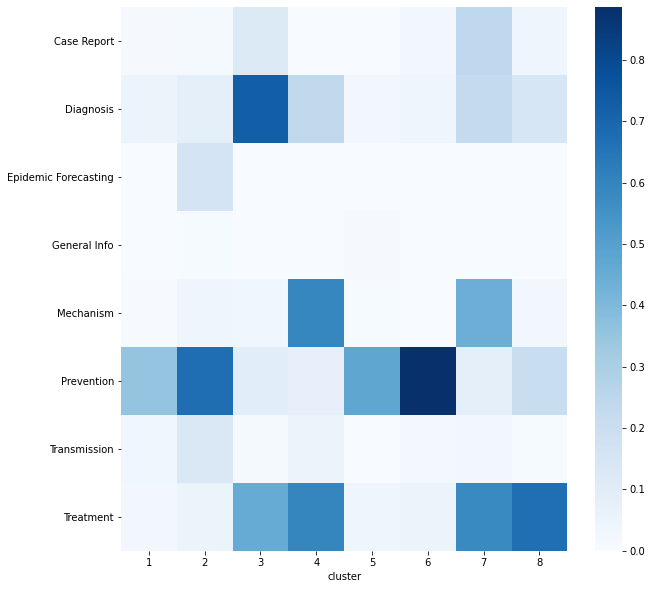

In [24]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(labels2.groupby('cluster').mean().T, cmap='Blues')

In [25]:
corpus2 = []
for i in range(0, len(result)):
    #Eliminamos puntuaciones y elementos que pueden llevar a error
    text = re.sub('[^a-zA-Z]', ' ', result['abstract'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convertimos de strings a listas de palabras
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]
    ##Eliminamos las stopwords
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lematizamos
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if x1[text.index(word)][1] =='n':
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
    text2 = " ".join(text2)
    corpus2.append(text2)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
corpus_np = np.array(corpus2)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
label_0 = np.where(df['cluster'] == 0)
label_1 = np.where(df['cluster'] == 1)
label_2 = np.where(df['cluster'] == 2)
label_3 = np.where(df['cluster'] == 3)
label_4 = np.where(df['cluster'] == 4)
label_5 = np.where(df['cluster'] == 5)
label_6 = np.where(df['cluster'] == 6)
label_7 = np.where(df['cluster'] == 7)
cluster0 = corpus_np[label_0]
cluster1 = corpus_np[label_1]
cluster2 = corpus_np[label_2]
cluster3 = corpus_np[label_3]
cluster4 = corpus_np[label_4]
cluster5 = corpus_np[label_5]
cluster6 = corpus_np[label_6]
cluster7 = corpus_np[label_7]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
stop_words=['data','coronavirs','covid','cov']

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


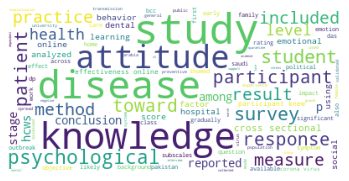

In [29]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster0))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


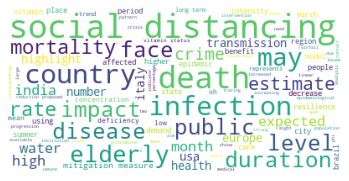

In [30]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster1))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


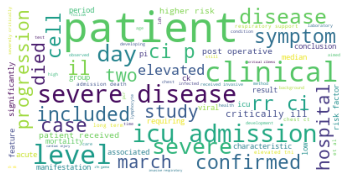

In [31]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster2))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


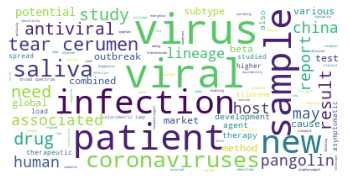

In [32]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster3))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


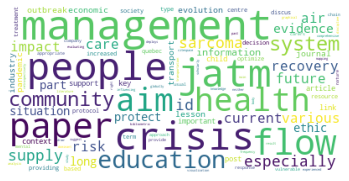

In [33]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster4))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


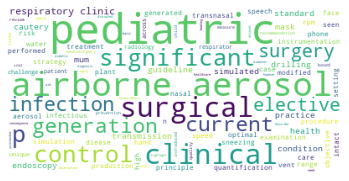

In [34]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster5))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


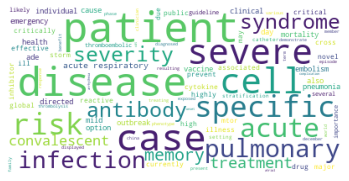

In [35]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster6))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


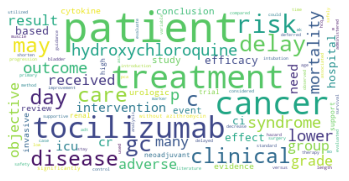

In [36]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(str(cluster7))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

## Busqueda de articulos por palabras

In [38]:
'''
Construimos el recomendado, este pide que paper has leido i cuantas recomendaciones quieres, a continuacion
coge todos los papers de la lista y hace las recomendaciones usando la distancia hellinger.
'''

paper = int(input("Que paper has leido?"))
num_papers = int(input("Cuantas recomendacioens quieres?"))
reccomendations = []
for i in range(0,len(result)):
    if i != paper:
        reccomendations.append(hellinger(ldamodel[corpus[paper]], ldamodel[corpus[i]]))
    else:
        reccomendations.append(0)
print(np.argsort(reccomendations)[::-1][:num_papers])

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Que paper has leido?1
Cuantas recomendacioens quieres?3
[17057 13443  1146]


In [39]:
### Imprimimos la matriz con el top recomendaciones
recs = np.argsort(reccomendations)[::-1][:num_papers]
img = pd.concat([labels2[paper:paper+1],labels2.iloc[recs]])
img = img.drop(columns = ['cluster'])
img.index = img.index.astype(str)
px.imshow(img.T)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
d:\ldamulticore\env\lib\site-packages\plotly\express\_imshow.py:349: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if img.dtype == np.bool:


In [40]:
# Creamos el indice con la posicion de cada documento y palabra
#lista de todas las palabras
l = data_words_clean
flatten = [item for sublist in l for item in sublist]
words = flatten
wordsunique = set(words)
wordsunique = list(wordsunique)

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [41]:
# creamos las funciones para TD-IDF / BM25
import math
from textblob import TextBlob as tb

def tf(word, doc):
    return doc.count(word) / len(doc)

def n_containing(word, doclist):
    return sum(1 for doc in doclist if word in doc)

def idf(word, doclist):
    return math.log(len(doclist) / (0.01 + n_containing(word, doclist)))

def tfidf(word, doc, doclist):
    return (tf(word, doc) * idf(word, doclist))

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [42]:
# Creamos el diccionario de palabras
plottest = data_words_clean[0:10000][0:1000]
worddic = {}

for doc in plottest:
    for word in wordsunique:
        if word in doc:
            word = str(word)
            index = plottest.index(doc)
            positions = list(np.where(np.array(plottest[index]) == word)[0])
            idfs = tfidf(word,doc,plottest)
            try:
                worddic[word].append([index,positions,idfs])
            except:
                worddic[word] = []
                worddic[word].append([index,positions,idfs])

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
print(worddic)

{'critically': [[0, [8], 0.034109447331170356], [4, [51, 70], 0.05684907888528392], [6, [5, 125, 133], 0.07257329219397947], [7, [55], 0.04872778190167193], [9, [15], 0.04804147511432444], [215, [20], 0.017402779250597116], [260, [64], 0.031008588482882137], [271, [27], 0.017858349388047305], [276, [71], 0.03789938592352261], [285, [58], 0.05414197989074659], [286, [132], 0.021055214401957005], [352, [8, 94, 103], 0.08387569015861562], [354, [73], 0.03311596828268966], [441, [27], 0.024716990819688662], [448, [137, 236], 0.028073619202609347], [456, [73, 298], 0.020363849152937524], [458, [27], 0.03344063463840231], [491, [26], 0.019831074029750206], [494, [87], 0.028663401118630548], [503, [11, 59], 0.08746012136197526], [516, [63], 0.04737423240440326], [529, [11, 65], 0.062017176965764274], [606, [71], 0.031008588482882137], [724, [137], 0.022440425875769967], [745, [72], 0.025454811441171905], [762, [28], 0.023046923872412403], [778, [78], 0.03667682508727995], [845, [14], 0.045479

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [44]:
# Creamos un buscador de papers que tiene como entrada una frase y recomienda un documento basado en lo siguiente:

    ## (1) Numero de veces que aparecen las search words
    ## (2) TD-IDF para las search words 
    ## (3) Porcentaje de los terminos buscados en el documento
    ## (4) Orden de las palabras
    ## (5) Palabras encontradas con el mismo orde 


from collections import Counter

def search(searchsentence):
    try:
        searchsentence = searchsentence.lower()
        try:
            words = searchsentence.split(' ')
        except:
            words = list(words)
        enddic = {}
        idfdic = {}
        closedic = {}
        realwords = []
        for word in words:
            if word in list(worddic.keys()):
                realwords.append(word)  
        words = realwords
        numwords = len(words)
        for word in words:
            for indpos in worddic[word]:
                index = indpos[0]
                amount = len(indpos[1])
                idfscore = indpos[2]
                enddic[index] = amount
                idfdic[index] = idfscore
                fullcount_order = sorted(enddic.items(), key=lambda x:x[1], reverse=True)
                fullidf_order = sorted(idfdic.items(), key=lambda x:x[1], reverse=True)
         
        combo = []
        alloptions = {k: worddic.get(k, None) for k in (words)}
        for worddex in list(alloptions.values()):
            for indexpos in worddex:
                for indexz in indexpos:
                    combo.append(indexz)
        comboindex = combo[::3]
        combocount = Counter(comboindex)
        for key in combocount:
            combocount[key] = combocount[key] / numwords
        combocount_order = sorted(combocount.items(), key=lambda x:x[1], reverse=True)
        
        if len(words) > 1:
            x = []
            y = []
            for record in [worddic[z] for z in words]:
                for index in record:
                     x.append(index[0])
            for i in x:
                if x.count(i) > 1:
                    y.append(i)
            y = list(set(y))

            closedic = {}
            for wordbig in [worddic[x] for x in words]:
                for record in wordbig:
                    if record[0] in y:
                        index = record[0]
                        positions = record[1]
                        try:
                            closedic[index].append(positions)
                        except:
                            closedic[index] = []
                            closedic[index].append(positions)
            x = 0
            fdic = {}
            for index in y:
                csum = []
                for seqlist in closedic[index]:
                    while x > 0:
                        secondlist = seqlist
                        x = 0
                        sol = [1 for i in firstlist if i + 1 in secondlist]
                        csum.append(sol)
                        fsum = [item for sublist in csum for item in sublist]
                        fsum = sum(fsum)
                        fdic[index] = fsum
                        fdic_order = sorted(fdic.items(), key=lambda x:x[1], reverse=True)
                    while x == 0:
                        firstlist = seqlist
                        x = x + 1
        else:
            fdic_order = 0

        
        
        return(searchsentence,words,fullcount_order,combocount_order,fullidf_order,fdic_order)
    
    except:
        return("")




d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [45]:
search("seas covid vaccine")[1]

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['vaccine']

In [46]:
# Creames el recomendador con las siguientes reglas:

# 1. Primero miramos si tenemos un paper que contenga todos los terminos buscados en orden
# 2. Despues recomendamos otros papers cuya metrica de orden de palabras supere 1
# 3. Añadimos el top TF-IDF
# 4. Añadimos otros papers con alto score de orden
# 5. Añadimos el resto de papers ordenados mediante todas las metricas

def rank(term):
    results = search(term)

    # get metrics 
    num_score = results[2]
    per_score = results[3]
    tfscore = results[4]
    order_score = results[5]
    
    final_candidates = []

    # Regla 1
    try:
        first_candidates = []

        for candidates in order_score:
            if candidates[1] > 1:
                first_candidates.append(candidates[0])

        second_candidates = []

        for match_candidates in per_score:
            if match_candidates[1] == 1:
                second_candidates.append(match_candidates[0])
            if match_candidates[1] == 1 and match_candidates[0] in first_candidates:
                final_candidates.append(match_candidates[0])

    # Regla 2

        t3_order = first_candidates[0:3]
        for each in t3_order:
            if each not in final_candidates:
                final_candidates.insert(len(final_candidates),each)

    # Regla 3
        final_candidates.insert(len(final_candidates),tfscore[0][0])
        final_candidates.insert(len(final_candidates),tfscore[1][0])

    # Regla 4
        t3_per = second_candidates[0:3]
        for each in t3_per:
            if each not in final_candidates:
                final_candidates.insert(len(final_candidates),each)

    # Regla 5
        othertops = [num_score[0][0],per_score[0][0],tfscore[0][0],order_score[0][0]]
        for top in othertops:
            if top not in final_candidates:
                final_candidates.insert(len(final_candidates),top)
                
    # en el caso de que se haya buscado un solo termino
    except:
        othertops = [num_score[0][0],num_score[1][0],num_score[2][0],per_score[0][0],tfscore[0][0]]
        for top in othertops:
            if top not in final_candidates:
                final_candidates.insert(len(final_candidates),top)
    for index, results in enumerate(final_candidates):
        if index < 5:
            print("RESULT", index + 1,  ":")
            print("Index :",final_candidates[index])
            print(data[results])

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [47]:
rank('vaccine')

RESULT 1 :
Index : 121
INTRODUCTION The Changchun Changsheng Vaccine Incident CCVI occurred mid and involved irregularities in the manufacture and quality control of diphtheria tetanus acellular pertussis and rabies vaccines This study investigates vaccine confidence amongst Chinese caregivers and vaccination service providers VSPs six months after the CCVI METHODS Quantitative surveys were conducted in January with caregivers of children and VSPs in three areas in China The proportions of respondents who agreed to the four statements from the Vaccine Confidence Index were used to measure vaccine confidence Descriptive and univariate analyses were performed to study the level of vaccine confidence Semi structured interviews were conducted with caregivers VSPs and immunization program managers Interviews were analyzed thematically using a combination of deductive and inductive coding Media surveillance was conducted to monitor public responses to the CCVI RESULTS Media surveillance indi

d:\ldamulticore\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

